In [1]:
## import packages
import pandas as pd
import dask.dataframe as dd
from functools import reduce
import matplotlib.pyplot as plt

In [2]:
store_ids = [1, 3]

In [3]:
def filter_data(chunk):
    chunk = chunk.replace(r'[^\sa-zA-Z0-9]',' ',regex=True)
    #chunk = chunk.replace(r'[ !"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','',regex=True)
    chunk = chunk.loc[(chunk['price'] >= 0) &
                      (chunk['store_id'].isin(store_ids))
                      , ['product_name', 'store_id', 'units']]
    return chunk.groupby(["store_id", 'product_name']).agg(sale_count=('units', 'sum'))

In [4]:
def add_chunk(previous_chunk, new_chunk):
    return pd.concat([previous_chunk, new_chunk], ignore_index=True)

# The transactions belonging to two stores should fit in the memory. The transaction contain refunds (unit <0) that must be filtered out. Calculate the relative sales.

In [5]:
# MapReduce structure:
transaction_chunks = pd.read_csv('Data/test_data.tsv', sep='\t', chunksize=1000)
filtered_chunks = map(filter_data, transaction_chunks)
transaction_df = reduce(add_chunk, filtered_chunks)

transaction_df['relative_sales'] = transaction_df['sale_count']/\
                                    transaction_df.groupby('store_id')['sale_count']\
                                        .transform('sum')
transaction_df.reset_index(inplace=True)
print(transaction_df)

   store_id   product_name  sale_count  relative_sales
0         1     bread 700g          46        0.154882
1         1   coffee large          95        0.319865
2         1  doughnut cold          53        0.178451
3         1        milk 2L          54        0.181818
4         1   snickers 37g          49        0.164983
5         3     bread 700g          65        0.188953
6         3   coffee large          57        0.165698
7         3  doughnut cold         125        0.363372
8         3        milk 2L          51        0.148256
9         3   snickers 37g          46        0.133721


In [6]:
#transaction_df.info()

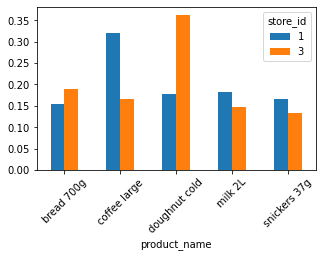

In [7]:
#Visualization: Bar plot
pivot_df = transaction_df.pivot_table(index='product_name', columns='store_id',
                                 values='relative_sales')
# plot
pivot_df.plot(kind='bar', figsize=(5, 3), rot=0)
plt.xticks(rotation=45)
#plt.tight_layout()
plt.show()